$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\vvec}{\mathbf{v}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\mathcal{B}}
    \newcommand{\sentinels}{\mathbf{b}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\tauw}{\tau^{w}}
    \newcommand{\unifavg}{\tau^{\mathrm{UNIF}}}
    \newcommand{\invvar}{\tau^{\mathrm{INV}}}
    \newcommand{\taurho}{\tau^{\rho}}
    \newcommand{\tauproj}{\tau^{\mathrm{PROJ}}}
    \newcommand{\taugeo}{\tau^{\mathrm{GEO}}}
    \newcommand{\taupop}{\tau^{\mathrm{POP}}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
    % NYC %
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\dvec}{\mathbf{d}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\district}{\mathtt{District}}
    \newcommand{\eqlabel}[1]{\label{#1}}
    %\renewcommand{\eqref}[1]{(\verbß#1ß)}
    \DeclareMathOperator{\proj}{proj}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\taubold}{\mathbf{\tau}}
$$

In [33]:
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

One problem with the current NYC output is that there are many significant results in the school district pairwise comparison that don't intuitively look like they should be significant.
In this notebook we explore sensitivity to the parameters to see if we can “fix” the “issue.”

In [34]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
using DataFrames
import PDMats: AbstractPDMat, PDMat
import Base: mean
using Distributions
using Base.LinAlg
using Distances
using GeoJSON
using LibGEOS
using Optim
using GLM
import MultivariateStats
import StatsModels
mvst=MultivariateStats
;

In [35]:
include("../src/GeoRDD.jl")


Use "MultiGPCovars{MT,KT1,KT2}(...) where {MT,KT1,KT2}" instead.


GeoRDD

# Dataset and Preprocessing

In [36]:
module NYC
    include("NYC.jl")
end
include("NYCPlots.jl")

NYCPlots

In [37]:
NYC_sales = NYC.read_processed_sales()

filtered = NYC.filter_sales(NYC_sales)

sentinels = NYC.read_sentinels()

model_dicts = NYC.sales_dicts(filtered[:filtered])
schdistr_indices = model_dicts[:schdistr_indices]
schdistrs = model_dicts[:schdistrs]
X_dict = model_dicts[:X_dict]
Y_dict = model_dicts[:Y_dict]
;

District 01 has 4 sales
District 02 has 80 sales
District 03 has 31 sales
District 04 has 6 sales
District 05 has 39 sales
District 06 has 30 sales
District 07 has 69 sales
District 08 has 739 sales
District 09 has 163 sales
District 10 has 312 sales
District 11 has 1172 sales
District 12 has 204 sales
District 13 has 321 sales
District 14 has 195 sales
District 15 has 516 sales
District 16 has 420 sales
District 17 has 459 sales
District 18 has 559 sales
District 19 has 686 sales
District 20 has 1010 sales
District 21 has 770 sales
District 22 has 1453 sales
District 23 has 245 sales
District 24 has 1283 sales
District 25 has 1317 sales
District 26 has 1268 sales
District 27 has 2199 sales
District 28 has 1033 sales
District 29 has 1956 sales
District 30 has 695 sales
District 31 has 0 sales
District 32 has 344 sales


In [38]:
d = NYC_sales[.!ismissing.(NYC_sales[:SchDistr]), :]
distr1 = d[:SchDistr].=="01"
res = [NYC.RESIDENTIAL_DICT[v] for v in d[NYC.BUILDING_CLASS_CATEGORY]]
sqft = .!ismissing.(d[NYC.SQFT])
d[res .& sqft .& distr1, :]

,,BOROUGH,BUILDING CLASS CATEGORY,BUILDING CLASS AT TIME OF SALE,TAX CLASS AT TIME OF SALE,TAX CLASS AT PRESENT,ADDRESS,BUILDING CLASS AT PRESENT,ZIP CODE,XCoord,YCoord,SchDistr,NEIGHBORHOOD,GROSS SQUARE FEET,SALE PRICE,SALE DATE,LAND SQUARE FEET,logSalePricePerSQFT
1,20302,Manhattan,03 THREE FAMILY DWELLINGS,C0,1.0,1,264 EAST 7TH STREET,C0,10009,990468.0,202794.0,"""01""",ALPHABET CITY,3696.0,3.775e6,2015-10-22,2059.0,6.9289
2,20426,Manhattan,17 CONDO COOPS,R9,2.0,2,342 EAST 8TH STREET,R9,10009,9.90098e5,2.03318e5,"""01""",ALPHABET CITY,65832.0,4.4e7,2016-03-05,17843.0,6.50484
3,21744,Manhattan,02 TWO FAMILY DWELLINGS,S2,1.0,1,54 2 AVENUE,S2,10003,987144.0,203623.0,"""01""",EAST VILLAGE,5772.0,6.9e6,2016-02-24,1440.0,7.08626
4,21745,Manhattan,02 TWO FAMILY DWELLINGS,S2,1.0,1,421/2 ST MARKS PLACE,S2,10003,987788.0,204602.0,"""01""",EAST VILLAGE,3325.0,3.375e6,2015-10-27,665.0,6.92268
5,21746,Manhattan,03 THREE FAMILY DWELLINGS,C0,1.0,1,319 EAST 6TH STREET,C0,10003,987739.0,204195.0,"""01""",EAST VILLAGE,4748.0,7.9204e6,2016-05-31,1635.0,7.41947


In [39]:
missing_sqft = d[res .& .!sqft, :]
size(missing_sqft)

(27394, 18)

## map of all sales

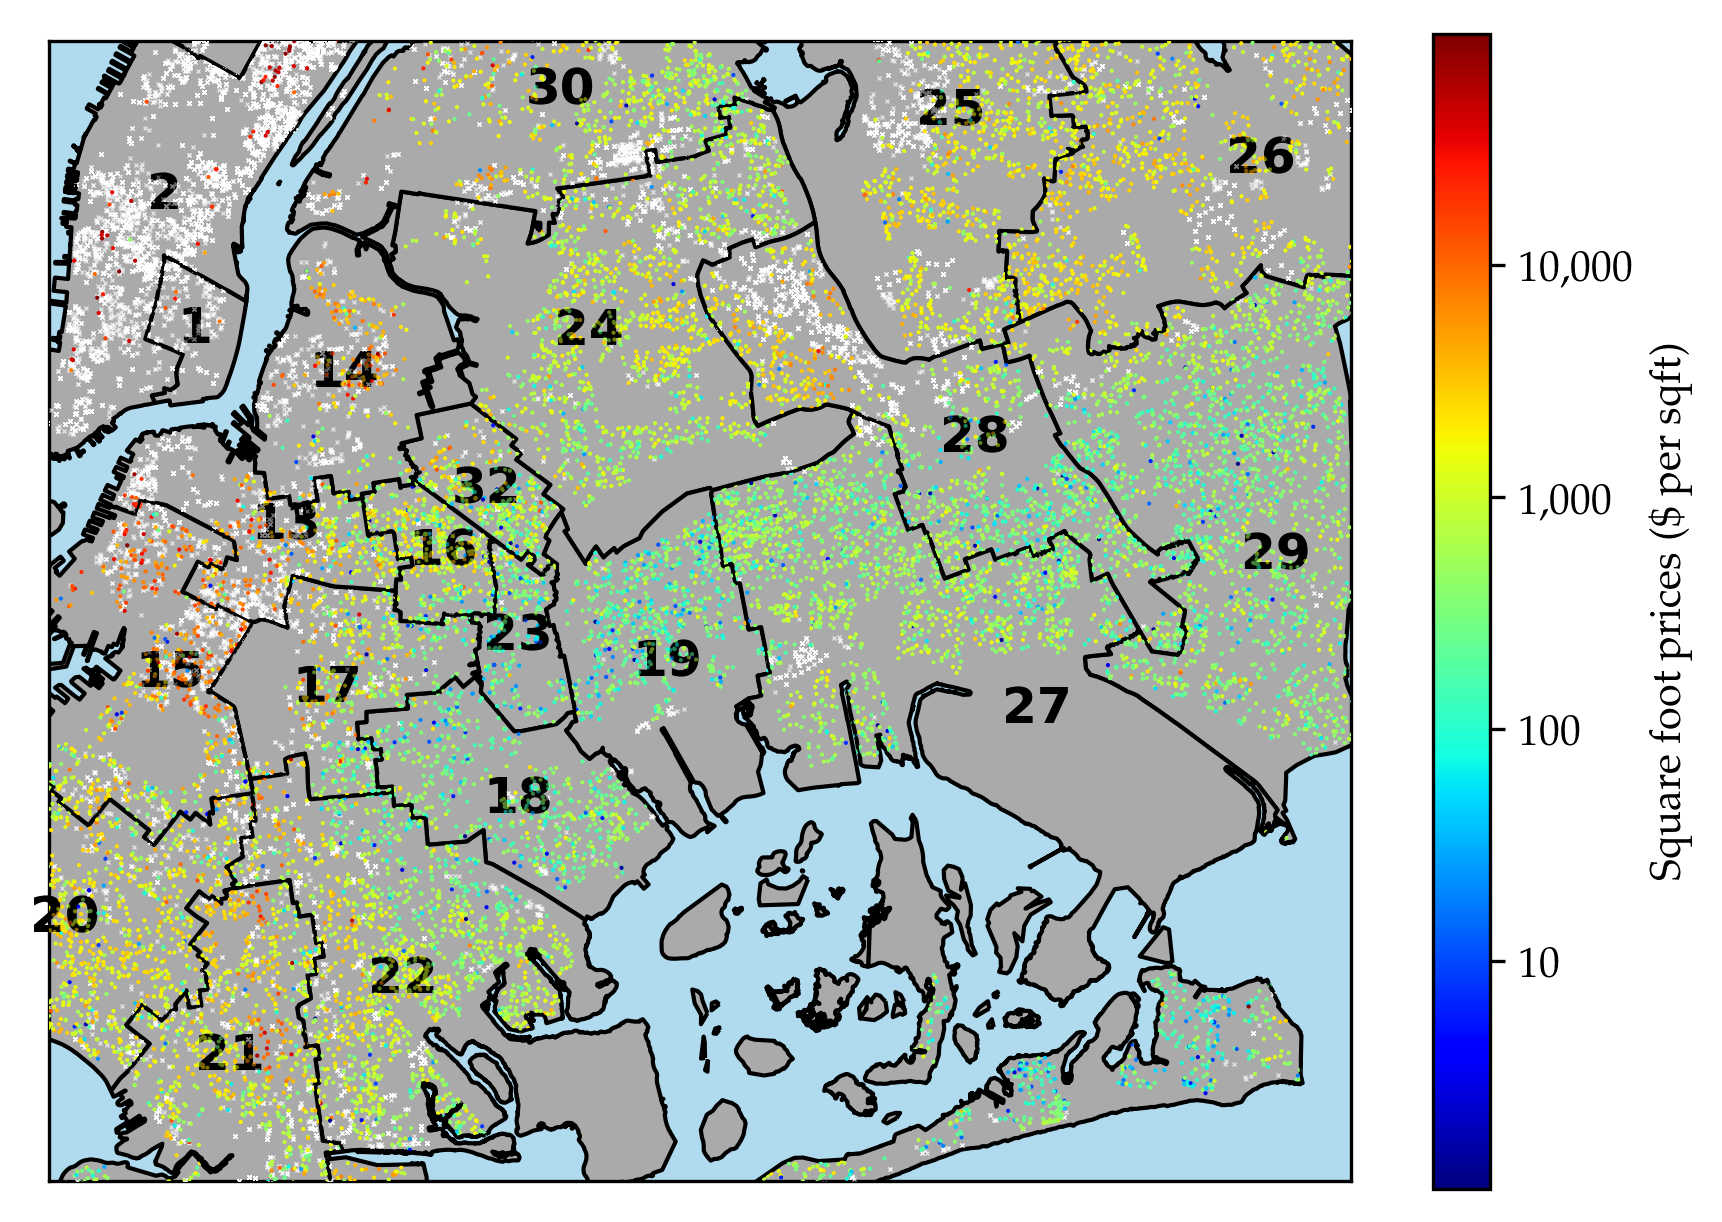

In [40]:
NYCPlots.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)

# model matrix

In [41]:
for_mm = DataFrame(
        Y=filtered[:filtered][:logSalePricePerSQFT],
        BUILDING=filtered[:filtered][NYC.BUILDING_CLASS_AT_TIME_OF_SALE],
        TAX=filtered[:filtered][NYC.TAX_CLASS_AT_TIME_OF_SALE]
)
size(for_mm)

(19578, 3)

In [42]:
mf = StatsModels.ModelFrame(@formula(Y ~ BUILDING + TAX),
    for_mm,
    contrasts = Dict(:BUILDING => StatsModels.FullDummyCoding(),
                          :TAX => StatsModels.FullDummyCoding()),
    )
mm = StatsModels.ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;
p

20

In [43]:
expected_p = length(unique(for_mm[:BUILDING].refs))+length(unique(for_mm[:TAX].refs))+1
@assert p == expected_p

# Modified kernel

In [44]:
GP_dict=Dict{String, GPE}()
k_mgpcv = SEIso(log(2000.0), log(1.0))
k_wmean = k_mgpcv + GaussianProcesses.fix(GeoRDD.ConstantKernel(log(20.0)))
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = Y_dict[name]
#     fit = GPE(X', Y, MeanConst(mean(Y)), k_mgpcv, log(1.0))
    fit = GPE(X', Y, MeanZero(), k_wmean, log(1.0))
    GP_dict[name] = fit
end

In [45]:
module MGPCV
    using GaussianProcesses
    using PDMats
    using Optim
    include("../src/multigp_covars.jl")
end


Use "MultiGPCovars{MT,KT1,KT2}(...) where {MT,KT1,KT2}" instead.


MGPCV

In [46]:
local_distrs = ["18","19","23","24","25","26","27","28","29"]
local_indices = vcat(collect(schdistr_indices[distr] for distr in local_distrs)...)

βkern_mgpcv = LinIso(log(1.0))
mgpcv=MGPCV.MultiGPCovars(D_[local_indices,:], [GP_dict[distr] for distr in local_distrs], βkern_mgpcv);

A single computation of the likelihood takes about 6 seconds, while computing the gradient takes about 30 seconds.

In [47]:
σ_diff = 0.2 # how much to scale up variance by
ℓ_diff = 3*σ_diff # how much to scale up lengthscale by
GeoRDD.set_params!(mgpcv, 
        [-0.911291 + σ_diff, # scaled variance (from fitted)
         8.4079 + ℓ_diff,    # scaled lengthscale (from fitted)
         -1.63199,
         1.92018], # output of previous optimization run
        noise=true,
        kern=true,
        mean=false,
        beta=true
        )
MGPCV.update_mll!(mgpcv)

-5968.528035537671

Marginal likelihood with optimal parameters is -5598.057182121601.

In [48]:
print(GeoRDD.get_params(mgpcv; mean=false))

[-0.711291, 9.0079, -1.63199, 1.92018]

The fitted hyperparameters are:

| Parameter      | Fitted Value                             |
|----------------|------------------------------------------|
| $\sigma_y$     | {{@sprintf("%.4f", exp(mgpcv.logNoise))}} |
| $\sigma_f$     | {{@sprintf("%.4f", √(mgpcv.k.kerns[1].σ2))}}        |
| $\sigma_\beta$ | {{@sprintf("%.4f", 1/√mgpcv.βkern.ℓ2)}}   |
| $\ell$ (feet)   | {{@sprintf("%.4f", √(mgpcv.k.kerns[1].ℓ2))}}       |

In [53]:
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(mgpcv.k.kerns[1].σ2))
@printf("σ_β: %.4f\n", 1/√mgpcv.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(mgpcv.k.kerns[1].ℓ2))

σ_y: 0.4910
σ_f: 0.1955
σ_β: 0.1466
ℓ: 8167.3518


## Get posterior mean $\beta$ using multiple districts

In [54]:
@time βhat = MGPCV.postmean_β(mgpcv)
βhat_dict=Dict(zip(coefnames(mf), βhat))

  6.199517 seconds (12.67 k allocations: 1.664 GiB, 7.78% gc time)


Dict{String,Float64} with 20 entries:
  "BUILDING: A1" => 0.06617
  "BUILDING: B2" => -0.0330646
  "BUILDING: A9" => 0.100157
  "BUILDING: B1" => -0.112672
  "BUILDING: A6" => -0.0551727
  "BUILDING: S1" => -0.0216453
  "BUILDING: A3" => 0.0646376
  "BUILDING: A8" => 0.0
  "BUILDING: A2" => 0.237397
  "BUILDING: B3" => 0.0417505
  "BUILDING: C0" => -0.232401
  "BUILDING: B9" => -0.114926
  "BUILDING: A5" => 0.0785223
  "BUILDING: S2" => -0.239773
  "BUILDING: A4" => 0.0349909
  "(Intercept)"  => 0.00276138
  "BUILDING: A7" => 0.0175919
  "TAX: 1.0"     => 0.00276138
  "BUILDING: S0" => -0.0785956
  "BUILDING: A0" => 0.249795

## Fit residuals with new $\hat\beta$ and hyperparameters

In [55]:
resid = for_mm[:Y] - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs
    resid_dict[name] = resid[schdistr_indices[name]]
end

In [56]:
write("NYC_data/processed/resid_multi.json", JSON.json(resid_dict))

352874

In [57]:
resid_GP_dict_multi=Dict{String, GPE}()
for name in schdistrs
    X = X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GPE(X', Y, MeanZero(), mgpcv.k, mgpcv.logNoise)
    resid_GP_dict_multi[name] = fit
end

# Pairwise

In [58]:
schdistr_shape_dict = NYC.read_distr_shapes()
;

In [59]:
function get_τpost(gp_i::GPE, gp_j::GPE, sentinelX::Matrix)
    μ, Σ = GeoRDD.cliff_face(gp_i, gp_j, sentinelX)
    τpost = GeoRDD.inverse_variance(μ, Σ)
    return τpost
end 

get_τpost (generic function with 1 method)

In [60]:
τpost_pairs = Dict{Tuple{String,String},Normal}()
for (distrA,distrB) in keys(sentinels)
    X◫ = hcat(sentinels[distrA,distrB].coordinates...)
    τpost = get_τpost(resid_GP_dict_multi[distrA], resid_GP_dict_multi[distrB], X◫)
    τpost_pairs[distrA,distrB] = τpost
end

In [61]:
τpost_pairs

Dict{Tuple{String,String},Distributions.Normal} with 117 entries:
  ("08", "11") => Distributions.Normal{Float64}(μ=-0.0682193, σ=0.0626219)
  ("32", "23") => Distributions.Normal{Float64}(μ=0.0469201, σ=0.0739904)
  ("23", "18") => Distributions.Normal{Float64}(μ=-0.121953, σ=0.0851951)
  ("06", "05") => Distributions.Normal{Float64}(μ=-0.242831, σ=0.136172)
  ("32", "16") => Distributions.Normal{Float64}(μ=0.0182301, σ=0.0603832)
  ("09", "07") => Distributions.Normal{Float64}(μ=-0.0842735, σ=0.115267)
  ("09", "10") => Distributions.Normal{Float64}(μ=-0.00658957, σ=0.0925263)
  ("24", "32") => Distributions.Normal{Float64}(μ=-0.0526802, σ=0.0759714)
  ("18", "22") => Distributions.Normal{Float64}(μ=-0.0518154, σ=0.0620785)
  ("14", "16") => Distributions.Normal{Float64}(μ=0.201201, σ=0.10261)
  ("22", "15") => Distributions.Normal{Float64}(μ=0.0581449, σ=0.0999352)
  ("22", "17") => Distributions.Normal{Float64}(μ=-0.0112542, σ=0.0725641)
  ("26", "25") => Distributions.Normal{Float

In [62]:
borders_dict = NYC.read_borders()
;

## pairwise plot

LibGEOS.

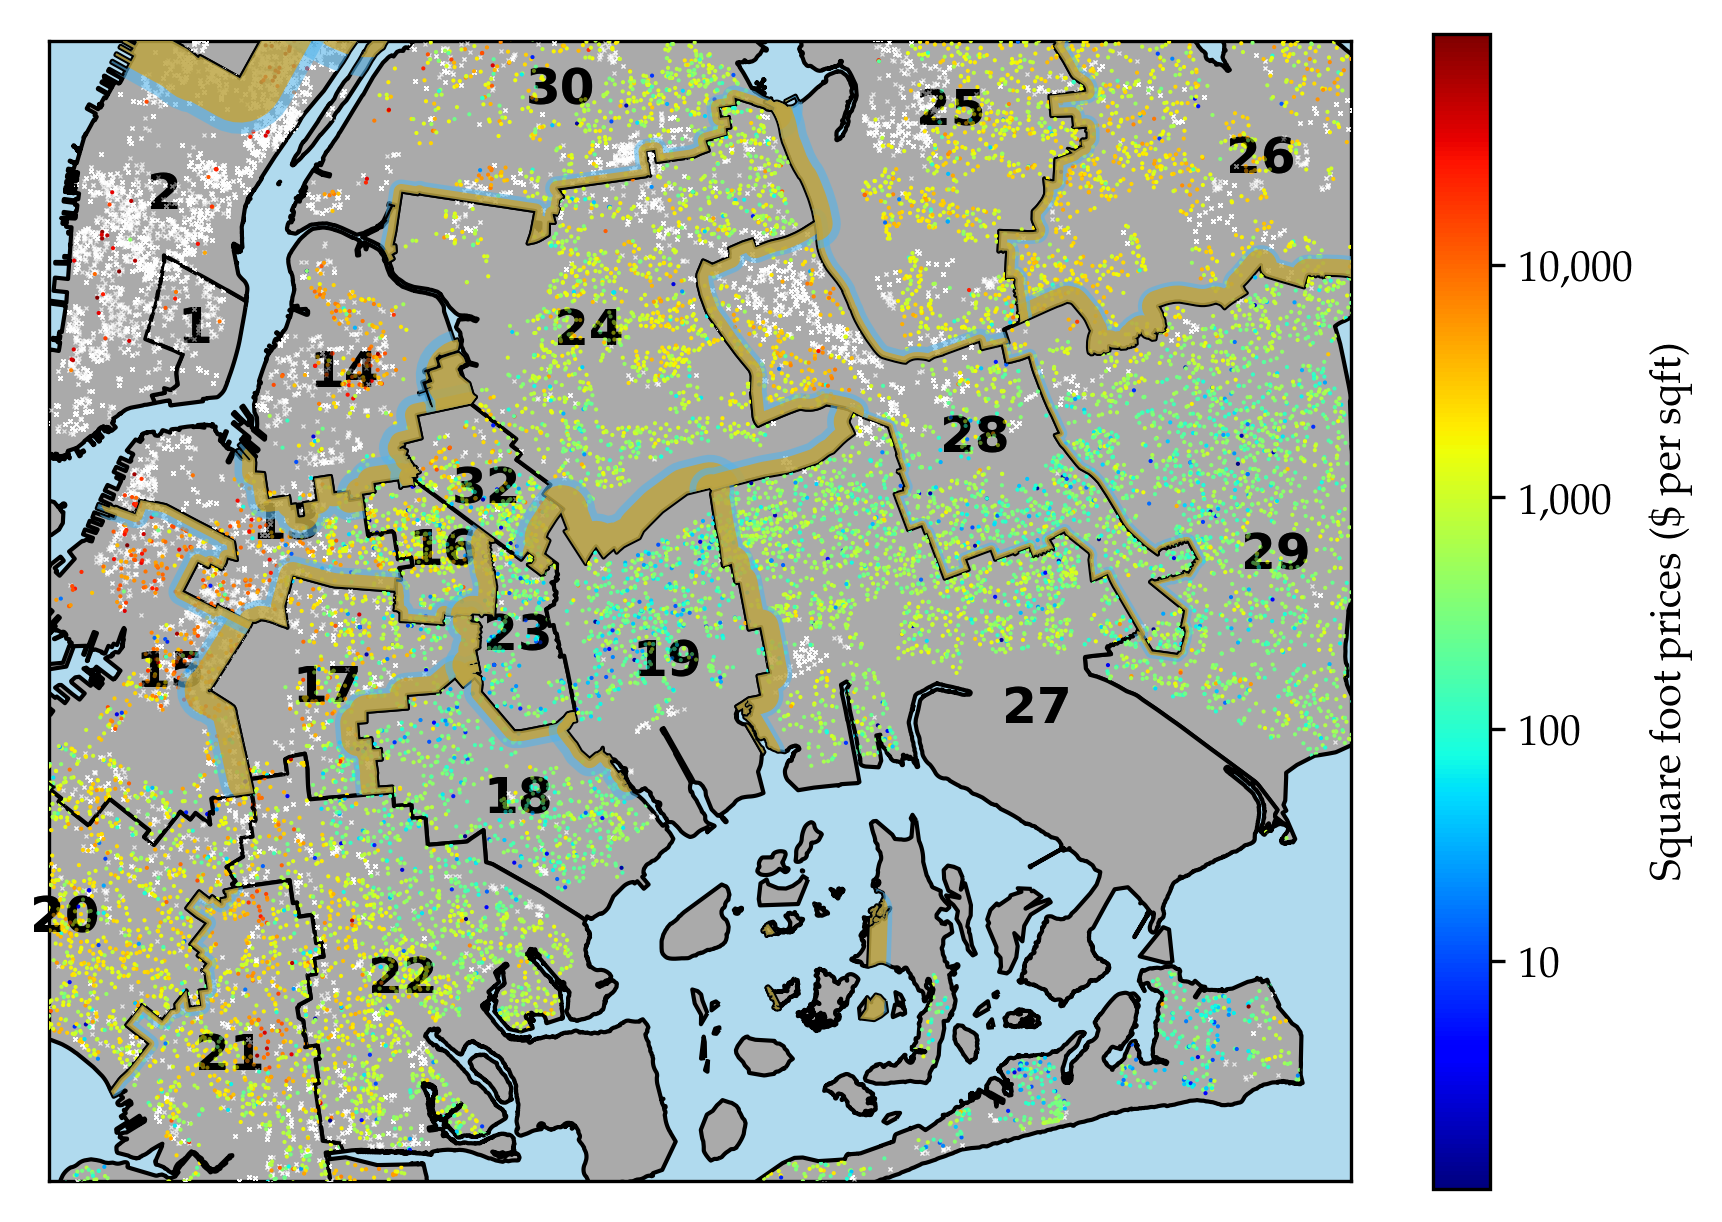

GeometryCollection
LibGEOS.GeometryCollection


(150000.0, 220000.0)

In [63]:
NYCPlots.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
_xlim = plt.xlim()
_ylim = plt.ylim()
NYCPlots.plot_all_pairs(τpost_pairs, sentinels, borders_dict, schdistr_shape_dict; scaleup=5000.0)
plt.xlim(_xlim)
plt.ylim(_ylim)
# plt.savefig("NYC_plots/pairwise_redblue.png")
# plt.savefig("NYC_plots/pairwise_redblue.pdf")

compared to the same plot with a squared exponential kernel

![](NYC_plots/pairwise_mean_se.png)

Observations:
* The drop in log likelihood is large (-5968 from -5598) $\rightarrow e^{-5968 + 5598} \approx 10^{-161}$, so not really justifiable.
* But the pairwise effects haven't hugely changed.
* In a way that's good, it means our results are somewhat robust to model specification. So we're not in the extrapolation regime where small changes to the model parameters (which don't affect the marginal log likelihood of the observed that much) can make big differences to the predictions further away.
* The questions remains: what's our story going to be for district 10 vs 27. I think it's actually fair enough to point out that the difference cannot be explained from typical spatial variation alone. But the presence of the park (Evergreen cemetery, Highland Park, Cypress Hills Cemetery, Forest Park) is a kind of physical barrier that could also explain the difference in price. The border between Brooklyn and Queens also overlaps with this school district border.

In [64]:
exp(-5968+5598)

2.0466411214592676e-161